# SSCx model fitting
This is an auxiliary notebook for configuring SSCx model fitting, which...
 - extracts required data
 - creates data-based models
 - visualizes data vs. model

...for different types of stochastic and auxiliary models, such as...
 - 1st..5th-order connection probability models
 - flatmap position model
 - distance-dependent delay model
 - physiological properties model

...and writes .json config file for running model building using <code>sbatch</code>

ℹ️ Part of reproduction of simplified connectomes experiment described in [Pokorny et al. (2024)](https://doi.org/10.1101/2024.05.24.593860)

<u>Requirements</u>:
- [Connectome-Manipulator](https://github.com/BlueBrain/connectome-manipulator) (Python venv)
- [SSCx network model](https://doi.org/10.5281/zenodo.8026353)


_SSCx network model:_ Download and extract `O1_data_physiology_withfix.xz` and set path accordingly:

In [1]:
# Path to SSCx network model
circuit_config = '/gpfs/bbp.cscs.ch/project/proj83/jira-tickets/NSETM-1948-extract-hex-O1/data/O1_data/circuit_config.json'

In [9]:
# Initialization

""" Global imports """
import json
import os
import matplotlib.pyplot as plt
import numpy as np

from voxcell.nexus.voxelbrain import Atlas

""" Local imports """
from connectome_manipulator.model_building import model_building

In [3]:
def default_model_config(output_path, circuit_name, circuit_config, seed=7531):
    """Generates a default model config dict w/o any specific model."""

    model_config = {}
    model_config['working_dir'] = os.path.join(output_path, circuit_name)
    model_config['out_dir'] = model_config['working_dir']
    model_config['seed'] = seed
    model_config['circuit_config'] = circuit_config

    return model_config

def export_model_config(model_config, config_path, print_cmd=True):
    """Writes model config to .json config file(s)."""
    if not isinstance(config_path, list):
        config_path = [config_path]

    fn = f'model_config__{model_config["model"]["name"]}.json'
    for cpath in config_path:
        if not os.path.exists(cpath):
            os.makedirs(cpath)
        with open(os.path.join(cpath, fn), 'w') as f:
            json.dump(model_config, f, indent=2)
        print(f"Config file {fn} written to {cpath}")
    # print(json.dumps(model_config, indent=2))

    if print_cmd:
        print()
        print_launch_cmd(cpath, fn)

def print_launch_cmd(config_path, config_fn):
    run_cmd = f"sbatch run_model_building.sh {config_fn} --force-reextract --force-rebuild"
    print(f"# LAUNCH COMMAND [CHECK ALLOCATION TIME!!]:")
    print(f"cd {config_path}")
    print(run_cmd)

ℹ️ Configure config and output paths:

In [4]:
# Model building configuration
circuit_name = 'SSCx-HexO1-Release'
output_path = '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/Zenodo/SSCx-connectome-manipulation-data/simplified_connectomes/model_building'
config_path = '../configs'  # Must exist!

In [5]:
# Check circuit
from bluepysnap import Circuit
c = Circuit(circuit_config)
nodes = c.nodes["S1nonbarrel_neurons"]
edges = c.edges["S1nonbarrel_neurons__S1nonbarrel_neurons__chemical"]
print(f"Total number of neurons: {nodes.size}")
print(f"Total number of synapses: {edges.size}")
nodes.get().head()

Total number of neurons: 211712
Total number of synapses: 407127134


,etype,exc_mini_frequency,inh_mini_frequency,layer,me_combo,model_template,model_type,morph_class,morphology,mtype,...,population,region,synapse_class,x,y,z,@dynamics:holding_current,@dynamics:input_resistance,@dynamics:resting_potential,@dynamics:threshold_current
node_ids,,,,,,,,,,,,,,,,,,,,,
0,bNAC,0.010108,0.233243,1,bNAC_L23SBC_L1_DAC_1_sm120429_2photon_a1-3_idA...,hoc:bNAC_L23SBC,biophysical,INT,sm120429_2photon_a1-3_idA_-_Scale_x1.000_y0.97...,L1_DAC,...,S1nonbarrel_neurons,S1FL,INH,4652.171846,-1930.525524,-1836.395782,-0.063857,163.571762,-74.320229,0.114051
1,cNAC,0.010108,0.233243,1,cNAC_L23NGC_L1_DAC_1_C270106A_-_Scale_x1.000_y...,hoc:cNAC_L23NGC,biophysical,INT,C270106A_-_Scale_x1.000_y1.025_z1.000,L1_DAC,...,S1nonbarrel_neurons,S1J,INH,4977.735899,-1641.041348,-2140.579908,-0.056414,192.304916,-73.626152,0.083738
2,bNAC,0.010108,0.233243,1,bNAC_L23NGC_L1_DAC_1_sm120429_2photon_a1-3_idA...,hoc:bNAC_L23NGC,biophysical,INT,sm120429_2photon_a1-3_idA_-_Scale_x1.000_y0.97...,L1_DAC,...,S1nonbarrel_neurons,S1J,INH,5011.718764,-1565.779688,-2212.599874,-0.059054,169.438538,-72.886154,0.084117
3,cNAC,0.010108,0.233243,1,cNAC_L6NGC_L1_DAC_1_sm090918b1-3_idB_-_Scale_x...,hoc:cNAC_L6NGC,biophysical,INT,sm090918b1-3_idB_-_Scale_x1.000_y0.950_z1.000,L1_DAC,...,S1nonbarrel_neurons,S1FL,INH,4266.789018,-1804.711830,-1531.716011,-0.100206,100.864609,-74.003380,0.157909
4,bNAC,0.010108,0.233243,1,bNAC_L23NGC_L1_DAC_1_C270106C_-_Scale_x1.000_y...,hoc:bNAC_L23NGC,biophysical,INT,C270106C_-_Scale_x1.000_y0.975_z1.000,L1_DAC,...,S1nonbarrel_neurons,S1FL,INH,4779.539653,-1259.558916,-1996.720501,-0.040889,247.846909,-72.796501,0.052005


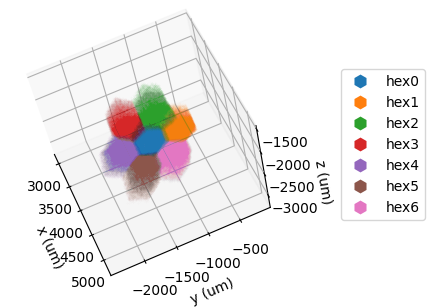

In [6]:
# Check hex columns
pos = nodes.get(properties=["x", "y", "z"])

plt.figure(figsize=(5, 3))
plt.subplot(1, 1, 1, projection='3d')
for hex_name in [f"hex{i}" for i in range(7)]:  # Hex column names
    pos = nodes.positions(hex_name)
    plt.plot(pos["x"], pos["y"], pos["z"], ".", markeredgewidth=0, markersize=3, label=hex_name, alpha=0.01)
plt.gca().set_xlabel("x (um)")
plt.gca().set_ylabel("y (um)")
plt.gca().set_zlabel("z (um)")
plt.axis("equal")
plt.gca().view_init(elev=50, azim=-10, roll=15)
lgd = plt.legend(loc="center left", bbox_to_anchor=[1.2, 0.5])
for h in lgd.legend_handles:
    h.set_alpha(1.0)
    h.set_markersize(10)
    h.set_marker("h")
plt.tight_layout()
plt.show()

In [10]:
# [MAY BE SKIPPED - Will take a while to extract]
# # Check central column (hex0)
# col_sel = "hex0"
# edges_table = edges.pathway_edges(col_sel, col_sel, properties=sorted(edges.property_names))
# conns, syn_conn_idx, num_syn_per_conn = np.unique(edges_table[['@source_node', '@target_node']], axis=0, return_inverse=True, return_counts=True)
# print(f"Number of neurons in {col_sel} column: {len(nodes.ids(col_sel))}")
# print(f"Number of synapses in {col_sel} column: {edges_table.shape[0]}")
# print(f"Number of connections in {col_sel} column: {len(conns)}")
# edges_table.head()

Number of neurons in hex0 column: 30190
Number of synapses in hex0 column: 41299369
Number of connections in hex0 column: 8291147


,@source_node,@target_node,Use_d_TM,Use_p_TM,afferent_center_x,afferent_center_y,afferent_center_z,afferent_section_id,afferent_section_pos,afferent_section_type,...,gmax_p_AMPA,n_rrp_vesicles,rho0_GB,spine_length,syn_type_id,theta_d,theta_p,u_hill_coefficient,u_syn,volume_CR
2076,38,7,0.0,0.0,4540.625000,-1449.925293,-1832.124268,1004,0.888235,2,...,0.0,1,0,1.245427,1,-1.0,-1.0,1.94,0.23588,0.0
2077,38,7,0.0,0.0,4500.894531,-1439.151001,-1787.693237,1002,0.918076,2,...,0.0,1,0,1.619549,1,-1.0,-1.0,1.94,0.23588,0.0
2078,38,7,0.0,0.0,4520.213867,-1406.050171,-1714.475708,1039,0.181500,2,...,0.0,1,0,0.167685,1,-1.0,-1.0,1.94,0.23588,0.0
2079,38,7,0.0,0.0,4526.350098,-1409.580322,-1712.011597,1039,0.297022,2,...,0.0,1,0,1.151088,1,-1.0,-1.0,1.94,0.23588,0.0
2080,38,7,0.0,0.0,4515.389648,-1400.375610,-1702.928833,1030,0.613816,2,...,0.0,1,0,0.311683,1,-1.0,-1.0,1.94,0.23588,0.0


In [7]:
# [MAY BE SKIPPED - Will take a while to extract]
# # Check EXC-EXC in central column (hex0)
# col_sel = "hex0"
# syn_class = "EXC"
# nids = nodes.ids(col_sel)
# nids = np.intersect1d(nids, nodes.ids({"synapse_class": syn_class}))
# edges_table = edges.pathway_edges(nids, nids, properties=sorted(edges.property_names))
# conns, syn_conn_idx, num_syn_per_conn = np.unique(edges_table[['@source_node', '@target_node']], axis=0, return_inverse=True, return_counts=True)
# print(f"Number of {syn_class} neurons in {col_sel} column: {len(nids)}")
# print(f"Number of {syn_class}-{syn_class} synapses in {col_sel} column: {edges_table.shape[0]}")
# print(f"Number of {syn_class}-{syn_class} connections in {col_sel} column: {len(conns)}")


Number of EXC neurons in hex0 column: 26787
Number of EXC-EXC synapses in hex0 column: 31212240
Number of EXC-EXC connections in hex0 column: 7203362


In [8]:
# # Show selected property values of a single connection
# conn_sel = 1
# props_sel = ["@source_node", "@target_node", "conductance", "conductance_scale_factor", "decay_time", "delay", "depression_time", "facilitation_time", "n_rrp_vesicles", "syn_type_id", "u_hill_coefficient", "u_syn"]
# edges_table[syn_conn_idx == conn_sel][props_sel]

,@source_node,@target_node,conductance,conductance_scale_factor,decay_time,delay,depression_time,facilitation_time,n_rrp_vesicles,syn_type_id,u_hill_coefficient,u_syn
1853850,473,1886,0.641791,0.7,1.707628,0.825998,676.711182,13.829699,1,115,2.79,0.166927
1853851,473,1886,1.019052,0.7,1.707628,1.054894,664.121643,13.144225,3,115,2.79,0.522873
1853852,473,1886,1.909985,0.7,1.707628,1.077844,672.153992,8.357350,5,115,2.79,0.809856
1853853,473,1886,0.423528,0.7,1.707628,1.098705,685.472412,6.837830,2,115,2.79,0.036728


## Create model building configs and run stochastic and auxiliary model building
- Central column (hex0) of SSCx-O1 connectome
- EXC-EXC connections only

ℹ️ To run model building, configure the SLURM script `run_model_building.sh` according to the used computation system and run below LAUNCH COMMANDS for generating the models.

ℹ️ All models are also contained in the Zenodo dataset

### Flat position mapping model (incl. inversion from depth to z axis)

Based on enhanced atlas published in [Bolaños-Puchet et al., 2023] (Zenodo DOI: [10.5281/zenodo.10686776](https://doi.org/10.5281/zenodo.10686776)). The published flat map does not contain "depth", but just "relative_depth". So "relative_depth" together with "thickness" can be used to define "depth" in um, which will be written to a separate "depth.nrrd" file.

ℹ️ Extract `rat_sscx_enhanced.zip` and set path below pointing to that folder:

In [10]:
flatmap_path = "/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/Zenodo/rat_sscx_enhanced"

In [11]:
# Prepare flat map
flatmap_atlas = Atlas.open(flatmap_path)
rel_depths = flatmap_atlas.load_data("relative_depth")
thickness = flatmap_atlas.load_data("thickness")
depths = flatmap_atlas.load_data("thickness")
depths.raw = rel_depths.raw * thickness.raw
depth_file = os.path.join(flatmap_path, "depth.nrrd")
depths.save_nrrd(depth_file, encoding="gzip")
print(f"Generated {depth_file}")


Generated /gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/Zenodo/rat_sscx_enhanced/depth.nrrd


In [13]:
model_config = default_model_config(output_path, circuit_name, circuit_config)
model_config['model'] = {'name': 'FlatPosMapping-SSCxO1',
                         'fct': {'source': 'pos_mapping',
                                 'kwargs': {'flatmap_path': '/gpfs/bbp.cscs.ch/project/proj83/home/pokorny/SimplifiedConnectomeModels/model_building_v2/rat_sscx_enhanced',  # v2 refinement (published data set)
                                            'xy_file': 'flatmap',
                                            'z_file': 'depth',
                                            'xy_scale': [34.0 * 189.0, 34.0 * 189.0],  # v2 refinement (new scaling for published data set from a.u. to um)
                                            'z_scale': -1.0}}}
### QUICK TESTING: 'NN_only': True
export_model_config(model_config, config_path)

Config file model_config__FlatPosMapping-SSCxO1.json written to ../configs

# LAUNCH COMMAND [CHECK ALLOCATION TIME!!]:
cd ../configs
sbatch run_model_building.sh model_config__FlatPosMapping-SSCxO1.json --force-reextract --force-rebuild


### Linear distance-dependent delay model

In [14]:
# Linear distance-dependent delay model
model_config = default_model_config(output_path, circuit_name, circuit_config)
model_config['model'] = {'name': 'DistDepDelay-SSCxO1-Hex0EE',
                         'fct': {'source': 'delay',
                                 'kwargs': {'sel_src': {'node_set': 'hex0', 'synapse_class': 'EXC'},
                                            'sel_dest': {'node_set': 'hex0', 'synapse_class': 'EXC'},
                                            'sample_size': None,
                                            'bin_size_um': 50,
                                            'max_range_um': None}}}
export_model_config(model_config, config_path)

Config file model_config__DistDepDelay-SSCxO1-Hex0EE.json written to ../configs

# LAUNCH COMMAND [CHECK ALLOCATION TIME!!]:
cd ../configs
sbatch run_model_building.sh model_config__DistDepDelay-SSCxO1-Hex0EE.json --force-reextract --force-rebuild


### Connection/synapse properties model

In [15]:
# Connection/synapse properties model
model_config = default_model_config(output_path, circuit_name, circuit_config)
model_config['model'] = {'name': 'ConnPropsPerPathway-SSCxO1-Hex0EE',
                         'fct': {'source': 'conn_props',
                                 'kwargs': {'sel_src': {'node_set': 'hex0', 'synapse_class': 'EXC'},
                                            'sel_dest': {'node_set': 'hex0', 'synapse_class': 'EXC'},
                                            'min_sample_size_per_group': 10,
                                            'max_sample_size_per_group': 10000,  # v2 refinement
                                            'distr_types': {'conductance': 'gamma',
                                                            'conductance_scale_factor': 'constant',
                                                            'decay_time': 'truncnorm',  # v2 refinement
                                                            'depression_time': 'gamma',  # v2 refinement
                                                            'facilitation_time': 'gamma',  # v2 refinement
                                                            'n_rrp_vesicles': 'discrete',  # v2 refinement
                                                            'n_syn_per_conn': 'discrete',  # v2 refinement
                                                            'syn_type_id': 'constant',
                                                            'u_hill_coefficient': 'constant',
                                                            'u_syn': 'truncnorm',  # v2 refinement
                                                            'Use_d_TM': 'zero',  # Not used
                                                            'Use_p_TM': 'zero',  # Not used
                                                            'gmax_d_AMPA': 'zero',  # Not used
                                                            'gmax_p_AMPA': 'zero',  # Not used
                                                            'rho0_GB': 'zero',  # Not used
                                                            'spine_length': 'zero',  # Not used
                                                            'theta_d': 'zero',  # Not used
                                                            'theta_p': 'zero',  # Not used
                                                            'volume_CR': 'zero'},  # Not used
                                            'data_types': {'n_rrp_vesicles': 'int',
                                                           'n_syn_per_conn': 'int',
                                                           'syn_type_id': 'int'},
                                            'data_bounds': {},  # v2 refinement (not needed any more)
                                            'plot_sample_size': 10000}}}  # v2 refinement (added to config)
export_model_config(model_config, config_path)

Config file model_config__ConnPropsPerPathway-SSCxO1-Hex0EE.json written to ../configs

# LAUNCH COMMAND [CHECK ALLOCATION TIME!!]:
cd ../configs
sbatch run_model_building.sh model_config__ConnPropsPerPathway-SSCxO1-Hex0EE.json --force-reextract --force-rebuild


### Connection probability models (1st-5th order)

In [17]:
# Required for 2nd-5th order models: Flat position mapping model
flatpos_model_file = f'{output_path}/{circuit_name}/model/FlatPosMapping-SSCxO1.json'

In [18]:
# Connection probability model: 1st-order model (uniform)
model_config = default_model_config(output_path, circuit_name, circuit_config)
model_config['model'] = {'name': 'ConnProb1stOrder-SSCxO1-Hex0EE',
                         'fct': {'source': 'conn_prob',
                                 'kwargs': {'order': 1,
                                            'sel_src': {'node_set': 'hex0', 'synapse_class': 'EXC'},
                                            'sel_dest': {'node_set': 'hex0', 'synapse_class': 'EXC'},
                                            'sample_size': None}}}
export_model_config(model_config, config_path)

Config file model_config__ConnProb1stOrder-SSCxO1-Hex0EE.json written to ../configs

# LAUNCH COMMAND [CHECK ALLOCATION TIME!!]:
cd ../configs
sbatch run_model_building.sh model_config__ConnProb1stOrder-SSCxO1-Hex0EE.json --force-reextract --force-rebuild


In [19]:
# Connection probability model: 2nd-order model (distance-dependent) => Complex exponential
model_config = default_model_config(output_path, circuit_name, circuit_config)
model_config['model'] = {'name': 'ConnProb2ndOrderComplex-SSCxO1-Hex0EE',
                         'fct': {'source': 'conn_prob',
                                 'kwargs': {'order': 2,
                                            'model_specs': {'type': 'ComplexExponential'},  # v2 refinement
                                            'sel_src': {'node_set': 'hex0', 'synapse_class': 'EXC'},
                                            'sel_dest': {'node_set': 'hex0', 'synapse_class': 'EXC'},
                                            'min_count_per_bin': 100,
                                            'bin_size_um': 50,
                                            'max_range_um': None,  # v2 refinement
                                            'sample_size': None,
                                            'pos_map_file': flatpos_model_file}}}
export_model_config(model_config, config_path)

Config file model_config__ConnProb2ndOrderComplex-SSCxO1-Hex0EE.json written to ../configs

# LAUNCH COMMAND [CHECK ALLOCATION TIME!!]:
cd ../configs
sbatch run_model_building.sh model_config__ConnProb2ndOrderComplex-SSCxO1-Hex0EE.json --force-reextract --force-rebuild


In [20]:
# Connection probability model: 3rd-order model (bipolar distance-dependent) => Complex exponential
model_config = default_model_config(output_path, circuit_name, circuit_config)
model_config['model'] = {'name': 'ConnProb3rdOrderComplex-SSCxO1-Hex0EE',
                         'fct': {'source': 'conn_prob',
                                 'kwargs': {'order': 3,
                                            'model_specs': {'type': 'ComplexExponential'},  # v2 refinement
                                            'sel_src': {'node_set': 'hex0', 'synapse_class': 'EXC'},
                                            'sel_dest': {'node_set': 'hex0', 'synapse_class': 'EXC'},
                                            'min_count_per_bin': 100,
                                            'bin_size_um': 50,
                                            'max_range_um': None,  # v2 refinement
                                            'sample_size': None,
                                            'pos_map_file': flatpos_model_file}}}
export_model_config(model_config, config_path)

Config file model_config__ConnProb3rdOrderComplex-SSCxO1-Hex0EE.json written to ../configs

# LAUNCH COMMAND [CHECK ALLOCATION TIME!!]:
cd ../configs
sbatch run_model_building.sh model_config__ConnProb3rdOrderComplex-SSCxO1-Hex0EE.json --force-reextract --force-rebuild


In [21]:
# Connection probability model: 4th-order (reduced) model (offset-dependent)
model_config = default_model_config(output_path, circuit_name, circuit_config)
model_config['model'] = {'name': 'ConnProb4thOrder-SSCxO1-Hex0EE',
                         'fct': {'source': 'conn_prob',
                                 'kwargs': {'order': '4R',
                                            'sel_src': {'node_set': 'hex0', 'synapse_class': 'EXC'},
                                            'sel_dest': {'node_set': 'hex0', 'synapse_class': 'EXC'},
                                            'min_count_per_bin': 100,
                                            'bin_size_um': 50,  # (same as 5th order!!)
                                            'max_range_um': [450, [-1550, 650]],  # v2 refinement
                                            'smoothing_sigma_um': None,
                                            'plot_model_ovsampl': 7,
                                            'plot_model_extsn': 0,
                                            'sample_size': None,
                                            'model_specs': {'type': 'LinearInterpolation'},
                                            'pos_map_file': flatpos_model_file}}}
export_model_config(model_config, config_path)

Config file model_config__ConnProb4thOrder-SSCxO1-Hex0EE.json written to ../configs

# LAUNCH COMMAND [CHECK ALLOCATION TIME!!]:
cd ../configs
sbatch run_model_building.sh model_config__ConnProb4thOrder-SSCxO1-Hex0EE.json --force-reextract --force-rebuild


In [22]:
# Connection probability model: 5th-order (reduced) model (position- & offset-dependent)
model_config = default_model_config(output_path, circuit_name, circuit_config)
model_config['model'] = {'name': 'ConnProb5thOrder-SSCxO1-Hex0EE',
                         'fct': {'source': 'conn_prob',
                                 'kwargs': {'order': '5R',
                                            'sel_src': {'node_set': 'hex0', 'synapse_class': 'EXC'},
                                            'sel_dest': {'node_set': 'hex0', 'synapse_class': 'EXC'},
                                            'min_count_per_bin': 100,
                                            'position_bin_size_um': 200,  # v2 refinement
                                            'position_max_range_um': [-2400, 200],  # v2 refinement
                                            'offset_bin_size_um': 50,  # v2 refinement (same as 4th order!!)
                                            'offset_max_range_um': [450, [-1550, 650]],  # v2 refinement (same as 4th order!!)
                                            'smoothing_sigma_um': None,
                                            'plot_model_ovsampl': 7,
                                            'plot_model_extsn': 0,
                                            'sample_size': None,
                                            'model_specs': {'type': 'LinearInterpolation'},
                                            'pos_map_file': flatpos_model_file}}}
export_model_config(model_config, config_path)

Config file model_config__ConnProb5thOrder-SSCxO1-Hex0EE.json written to ../configs

# LAUNCH COMMAND [CHECK ALLOCATION TIME!!]:
cd ../configs
sbatch run_model_building.sh model_config__ConnProb5thOrder-SSCxO1-Hex0EE.json --force-reextract --force-rebuild


---
ℹ️ Once all models have been successfully built, proceed with rewiring!

---